In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
from sklearn.model_selection import train_test_split

Importujemy dane. Dane użyte do modelu to: dsprites 

In [ ]:
ds_train, ds_info = tfds.load('dsprites', split='train', shuffle_files=True, with_info=True)
print(ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/dsprites/2.0.0.incompleteWDSJ98/dsprites-train.tfrecord


  0%|          | 0/737280 [00:00<?, ? examples/s]

Dataset dsprites downloaded and prepared to /root/tensorflow_datasets/dsprites/2.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='dsprites',
    version=2.0.0,
    description='dSprites is a dataset of 2D shapes procedurally generated from 6 ground truth
independent latent factors. These factors are *color*, *shape*, *scale*,
*rotation*, *x* and *y* positions of a sprite.

All possible combinations of these latents are present exactly once,
generating N = 737280 total images.

### Latent factor values

*   Color: white
*   Shape: square, ellipse, heart
*   Scale: 6 values linearly spaced in [0.5, 1]
*   Orientation: 40 values in [0, 2 pi]
*   Position X: 32 values in [0, 1]
*   Position Y: 32 values in [0, 1]

We varied one latent at a time (starting from Position Y, then Position X, etc),
and sequentially stored the images in fixed order.
Hence the order along the first dimension is fixed and allows you to map back to
the value of the latents corresponding 

wyświetlamy przykłady zawarte w danych. Opracowujemy grupowanie ze względu na kształt.

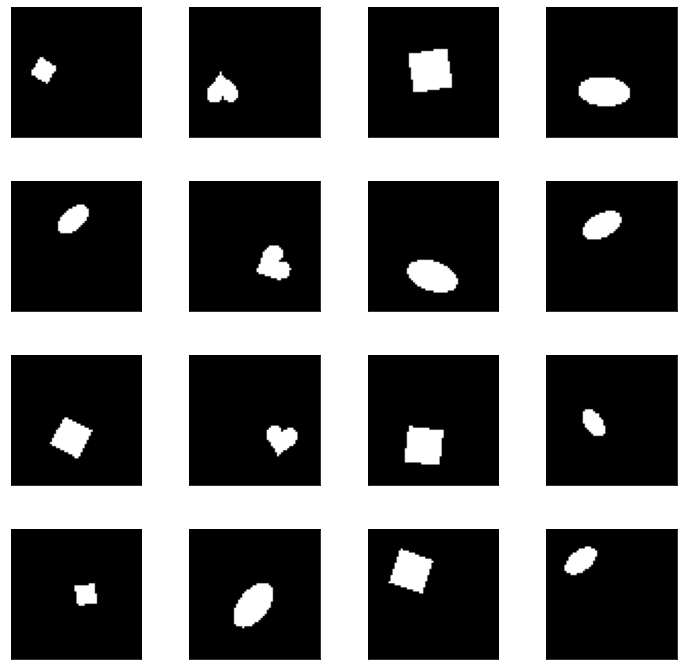

In [ ]:
fig = tfds.show_examples(ds_train, ds_info, rows=4, cols=4)

In [ ]:
type(ds_train)

tensorflow.python.data.ops.dataset_ops._OptionsDataset

In [ ]:
images = []
labels = []

for example in ds_train:  
  images.append(example["image"])
  labels.append(example["label_shape"])

In [ ]:
images, binX, labels, binY = train_test_split(images, labels, test_size=0.75, random_state=42)

In [ ]:
len(images)

184320

In [ ]:
images = np.array(images)
labels = np.array(labels)

Deklarujemy zmienne testowe.

In [ ]:
trainX, testX, trainY, testY = train_test_split(images, labels, test_size=0.3, random_state=42)

In [ ]:
trainX.shape

(129024, 64, 64, 1)

In [ ]:
trainX1 = trainX.reshape(-1, 64*64)

In [ ]:
trainX1.shape

(129024, 4096)

In [ ]:
testX1 = testX.reshape(-1, 64*64)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

model = Sequential(
    [
      Dense(256, input_shape=(4096, ), activation='relu'),
      Dense(516, activation='relu'),
      Dense(3)
    ]
)

model.summary()

model.compile(
    loss = SparseCategoricalCrossentropy(from_logits=True),
    optimizer = Adam(learning_rate=0.001),
    metrics = ['accuracy']
)

model.fit(trainX1, trainY, batch_size=32, epochs=5, verbose=2)
model.evaluate(testX1, testY, batch_size=32, verbose=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1048832   
                                                                 
 dense_1 (Dense)             (None, 516)               132612    
                                                                 
 dense_2 (Dense)             (None, 3)                 1551      
                                                                 
Total params: 1,182,995
Trainable params: 1,182,995
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
4032/4032 - 40s - loss: 0.5135 - accuracy: 0.7493 - 40s/epoch - 10ms/step
Epoch 2/5
4032/4032 - 37s - loss: 0.1170 - accuracy: 0.9538 - 37s/epoch - 9ms/step
Epoch 3/5
4032/4032 - 37s - loss: 0.0764 - accuracy: 0.9714 - 37s/epoch - 9ms/step
Epoch 4/5
4032/4032 - 36s - loss: 0.0599 - accuracy: 0.9779 

[0.058241989463567734, 0.9788954257965088]

model prostej sieci neuronowej. Model zawiera 3 warstwy i został wykonany 5 razy(epoch=5). Accuracy modelu wynosi prawie 98%. Wynik pokazuje bardzo dobre dopasowanie modelu do danych.

In [ ]:
trainY.shape
testY.shape

(55296,)

In [ ]:
trainYohe = np.zeros((trainY.size, trainY.max()+1))
trainYohe[np.arange(trainY.size),trainY] = 1
trainYohe

testYohe = np.zeros((testY.size, testY.max()+1))
testYohe[np.arange(testY.size),testY] = 1
testYohe

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
from keras.layers import MaxPool2D
from keras.layers import Conv2D
from keras.layers import Flatten

model = Sequential(
    [
     # Dodawanie splotów oraz łączenia maksymalnego
      Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same', input_shape=(64, 64, 1)),
      MaxPool2D(pool_size=(2,2), strides=2),
      Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
      MaxPool2D(pool_size=(2,2), strides=2),
      Flatten(),
      Dense(units=3, activation='softmax')
    ]
)

model.summary()

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate=0.001),
    metrics = ['accuracy']
)

model.fit(trainX, trainYohe, validation_split=0.3, batch_size=32, epochs=3, verbose=2)
model.evaluate(testX, testYohe, batch_size=32, verbose=2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense_3 (Dense)             (None, 3)                

[0.1333804428577423, 0.9522750377655029]

model splotowej sieci neuronowej z accuracy na poziomie około 95%. Rozmiar łączenia 3 na 3. Liczba sesji trenujących(epochs): 3

In [ ]:
model1 = Sequential(
    [
      Conv2D(filters=8, kernel_size=(4,4), activation='relu', padding='same', input_shape=(64, 64, 1)),
      MaxPool2D(pool_size=(3,3), strides=3),
      Conv2D(filters=16, kernel_size=(4,4), activation='relu', padding='same'),
      MaxPool2D(pool_size=(3,3), strides=3),
      Flatten(),
      Dense(units=3, activation='softmax')
    ]
)

model1.summary()

model1.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate=0.001),
    metrics = ['accuracy']
)

model1.fit(trainX, trainYohe, validation_split=0.3, batch_size=32, epochs=4, verbose=2)
model1.evaluate(testX, testYohe, batch_size=32, verbose=2)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 64, 64, 8)         136       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 21, 21, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 21, 21, 16)        2064      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 7, 7, 16)         0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 3)                

[0.009756009094417095, 0.9983362555503845]

model splotowej sieci neuronowej z accuracy na poziomie około ~100%. Rozmiar łączenia 4 na 4. Liczba sesji trenujących:4.